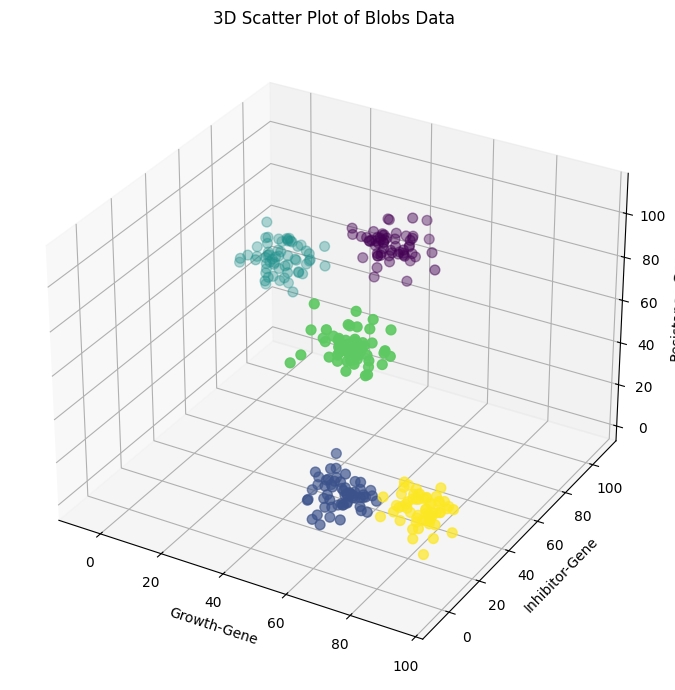

In [8]:
## Generate mock data via sklearn 
from sklearn import datasets
n_samples = 300
seed = 42
blobs = datasets.make_blobs(
    n_samples=n_samples, 
    random_state=seed, 
    n_features=3, 
    centers=5, 
    cluster_std=5.0,
    center_box=(0, 100)  # Centers will be in [0, 100] range
)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(blobs[0][:, 0], blobs[0][:, 1], blobs[0][:, 2], c=blobs[1], cmap='viridis', s=50)
ax.set_xlabel('Growth-Gene')
ax.set_ylabel('Inhibitor-Gene')
ax.set_zlabel('Resistance-Gene')
plt.title('3D Scatter Plot of Blobs Data')
plt.tight_layout()
plt.show()## Save the data to a parquet file
import pandas as pd
df = pd.DataFrame(blobs[0], columns=['Gene1', 'Gene2', 'Gene3'])
df.index = [f'Sample_{i:03d}' for i in range(1, n_samples + 1)]
df.to_csv('./data/gene_expression_blobs.csv', index=True)
df.to_parquet('blobs_data.parquet', index=True)
## Save second blobs annotation file
df_annotations = pd.DataFrame({'Cluster': [f'Cluster_{label+1}' for label in blobs[1]]})
df_annotations.index = df.index
df_annotations.to_parquet('blobs_annotations.parquet', index=True)

In [6]:
## Generate small representative dataset with 30 samples
from sklearn import datasets
import pandas as pd

n_samples_small = 30
seed = 42
blobs_small = datasets.make_blobs(
    n_samples=n_samples_small, 
    random_state=seed, 
    n_features=3, 
    centers=5, 
    cluster_std=5.0,
    center_box=(0, 100)
)

# Create dataframe
df_small = pd.DataFrame(blobs_small[0], columns=['Gene1', 'Gene2', 'Gene3'])
df_small.index = [f'Sample_{i:03d}' for i in range(1, n_samples_small + 1)]

# Save to CSV
df_small.to_csv('./data/gene_expression_blobs_30samples.csv', index=True)

print(f"Created 30-sample dataset with shape: {df_small.shape}")
print(df_small.head())

Created 30-sample dataset with shape: (30, 3)
                Gene1      Gene2       Gene3
Sample_001  65.618108   1.679431  101.855803
Sample_002   2.690974  79.076848   65.609736
Sample_003  65.325810  29.493429   21.567651
Sample_004   1.317322  90.791592   61.594308
Sample_005   6.480506  89.528229   64.550243


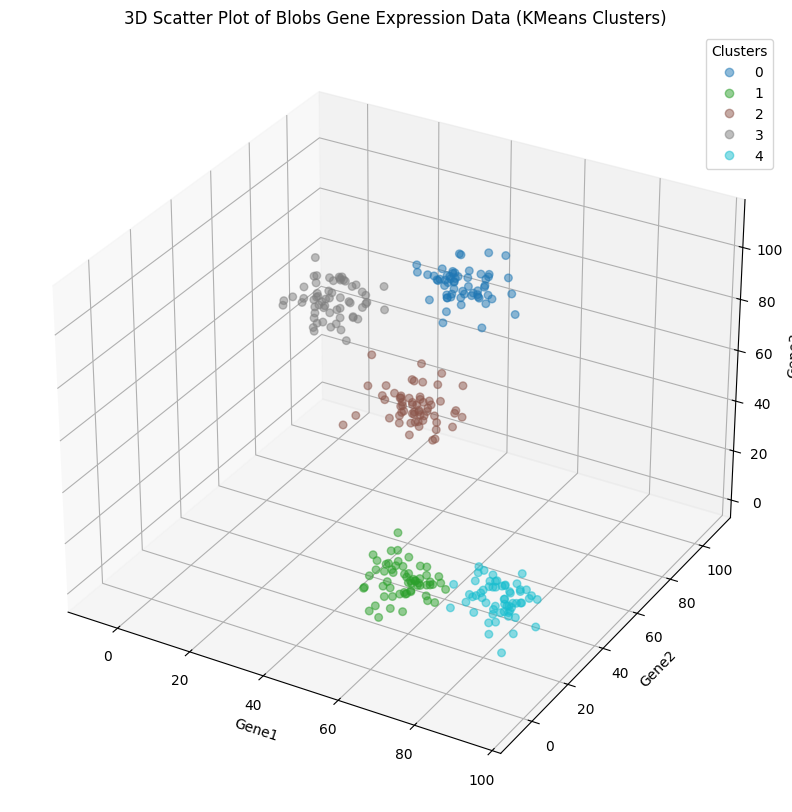

Saved 300 samples to ./data/gene_ex_blobs.parquet
Cluster distribution: Cluster
Cluster_1    60
Cluster_2    60
Cluster_3    60
Cluster_4    60
Cluster_5    60
Name: count, dtype: int64


In [13]:
# ## Gene Expression blobs example

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df_blobs = df.copy()

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_blobs[['Gene1', 'Gene2', 'Gene3']])
df_blobs['Cluster'] = [f'Cluster_{i+1}' for i in cluster_labels]

# Create annotation dataframe
df_blobs_anno = pd.DataFrame({
	'sample_id': df_blobs.index,
	'Cluster': df_blobs['Cluster'].values
})
df_blobs_anno.set_index('sample_id', inplace=True)

## Plot in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_blobs['Gene1'], df_blobs['Gene2'], df_blobs['Gene3'],
					 c=cluster_labels, cmap='tab10', s=30, alpha=0.5)
ax.set_xlabel('Gene1')
ax.set_ylabel('Gene2')
ax.set_zlabel('Gene3')
ax.set_title('3D Scatter Plot of Blobs Gene Expression Data (KMeans Clusters)')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

# Save as parquet (without Cluster column)
output_file = "./data/gene_ex_blobs.parquet"
df_blobs.drop(columns=['Cluster']).to_parquet(output_file)

# Save annotations
anno_file = "./data/gene_ex_blobs_annotations.parquet"
df_blobs_anno.to_parquet(anno_file)

print(f"Saved {len(df_blobs)} samples to {output_file}")
print(f"Cluster distribution: {df_blobs['Cluster'].value_counts().sort_index()}")


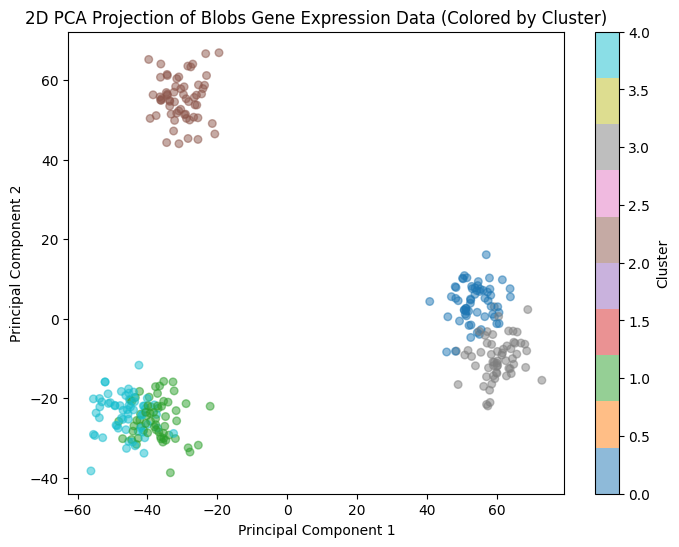

In [14]:
## Make 2D projections with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_blobs[['Gene1', 'Gene2', 'Gene3']])
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca.index = df_blobs.index
df_pca.head()
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=cluster_labels, cmap='tab10', s=30, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Projection of Blobs Gene Expression Data (Colored by Cluster)')
plt.colorbar(label='Cluster')
plt.show()

In [19]:
import os
from autoencodix.configs.default_config import DataConfig, DataInfo, DefaultConfig
from autoencodix.configs.default_config import DataCase


root_dir = os.path.join("./data")
# gene_expression_file = "gene_ex_blobs.parquet"
gene_expression_file = "gene_ex_blobs.parquet"
# anno_file = "gene_ex_blobs_annotations.parquet"
anno_file = "gene_ex_blobs_annotations.parquet"

## Config definition
my_config_blob = DefaultConfig(
	data_case=DataCase.MULTI_BULK,
	k_filter=3,
	epochs=500,
	learning_rate=0.005,
	n_layers=0,
	latent_dim=2,
	batch_size=16,
	weight_decay=0.01,
	beta = 0.005,
    checkpoint_interval=1,
    data_config=DataConfig(
        data_info={
            "EXPRESSION": DataInfo(file_path=os.path.join(root_dir, gene_expression_file), scaling="STANDARD"),
            "ANNO": DataInfo(
                file_path=os.path.join(root_dir, anno_file), data_type="ANNOTATION",
				
            ),
        }
    )
)


In [16]:
## Run autoencoder training
import autoencodix as acx

# var = acx.Varix(config=my_config_mammoth)
# var = acx.Vanillix(config=my_config_mammoth)

var = acx.Varix(config=my_config_blob)
# var = acx.Vanillix(config=my_config_linear)
# var = acx.Vanillix(config=my_config_blob)



# var.run()

### Run autoencoder training
#import autoencodix as acx
#
## var = acx.Varix(config=my_config_mammoth)
## var = acx.Vanillix(config=my_config_mammoth)
#
# var = acx.Varix(config=my_config_blob)
## var = acx.Vanillix(config=my_config_blob)
#
#
#
var.run()

/home/alicia/dev/biomarker_autoencoder/autoencodix_package/src/autoencodix/base/_base_pipeline.py:192: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.varix_config.VarixConfig'> work best
  warnings.warn(


reading parquet: ./data/gene_ex_blobs.parquet
reading parquet: ./data/gene_ex_blobs_annotations.parquet
anno key: paired
Epoch 1 - Train Loss: 4.4500
Sub-losses: recon_loss: 4.4500, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 4.1781
Sub-losses: recon_loss: 4.1781, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 4.2865
Sub-losses: recon_loss: 4.2865, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 4.6032
Sub-losses: recon_loss: 4.6032, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 4.1782
Sub-losses: recon_loss: 4.1782, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 3.8181
Sub-losses: recon_loss: 3.8181, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 3.9284
Sub-losses: recon_loss: 3.9284, var_loss: 0.0000, anneal_f

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7dc13a525cc0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7dc13a525ae0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7dc13a524f10>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 60 × 2
    uns: 'var_names'
final_reconstruct

Creating plots ...


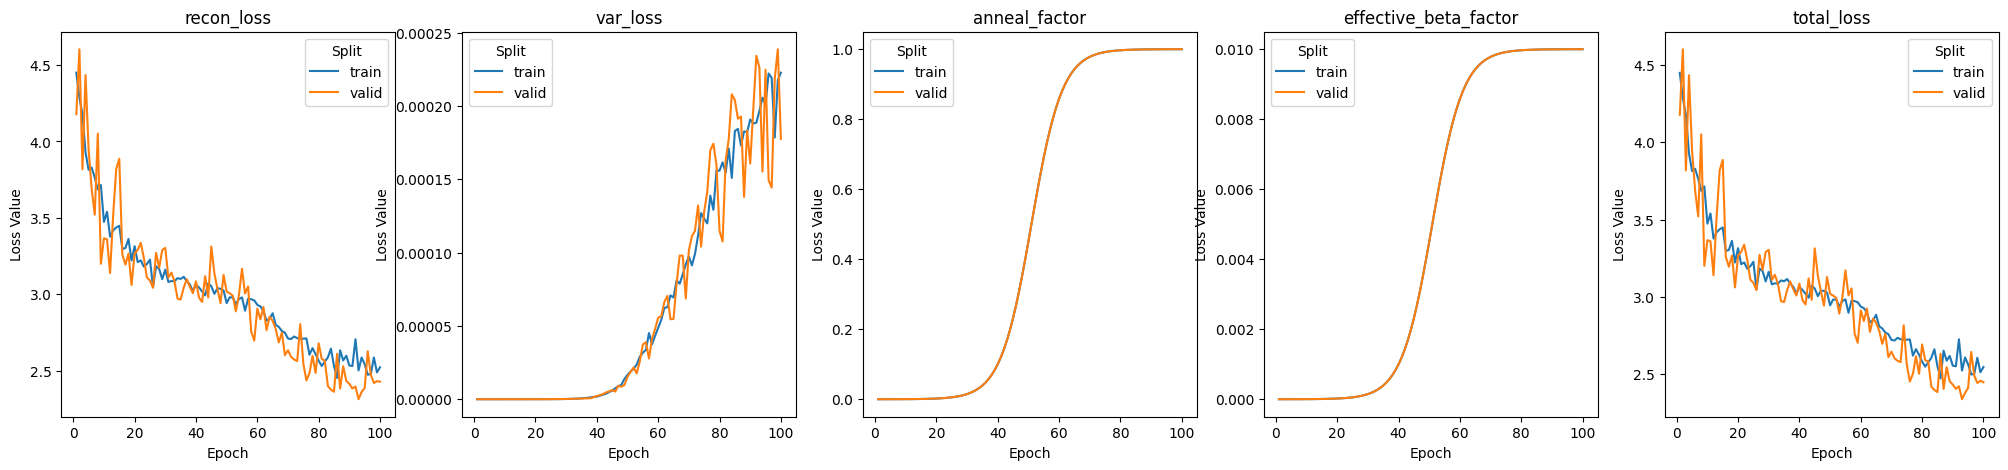

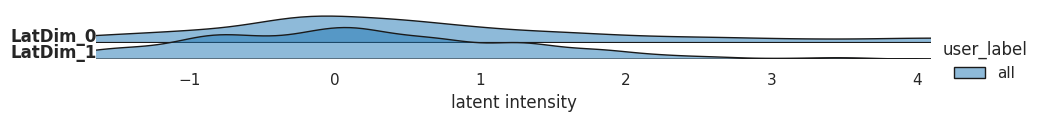

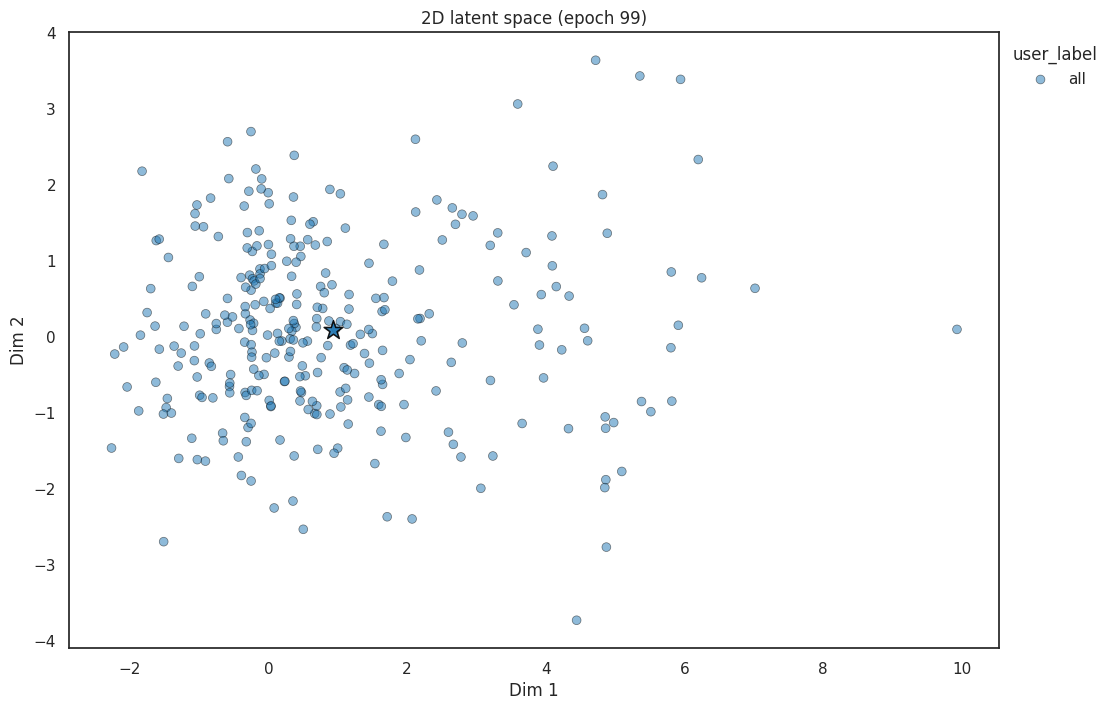

In [17]:
## Check result plots
var.show_result()

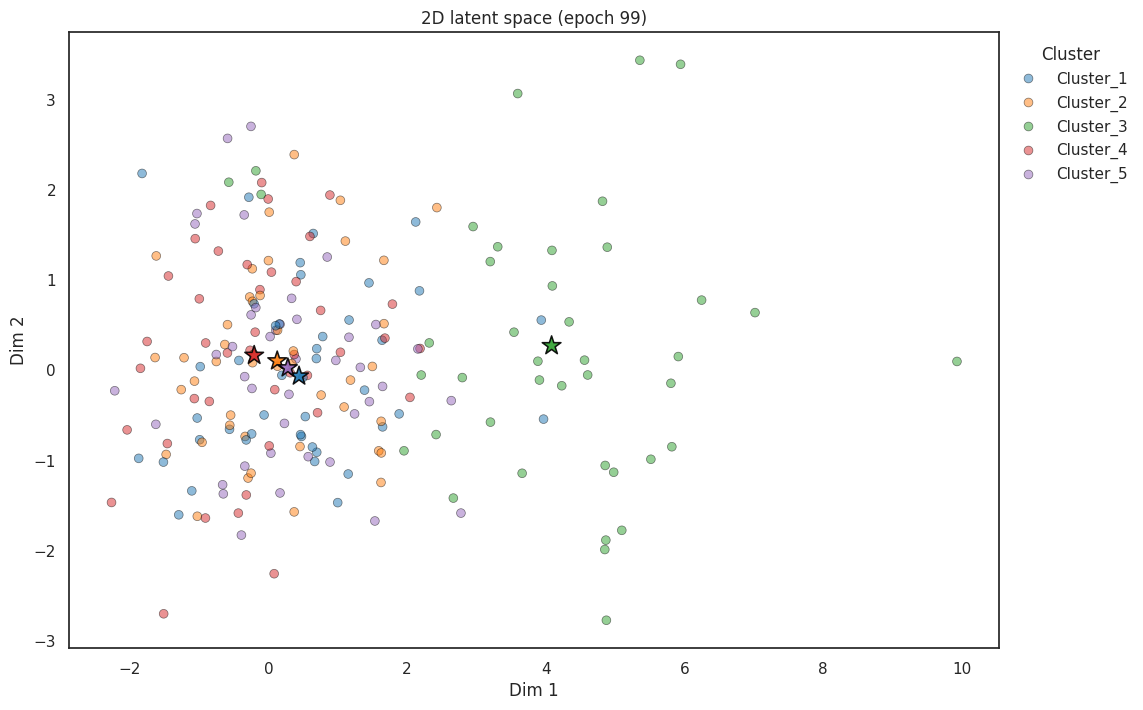

In [18]:
var.visualizer.show_latent_space(result=var.result, plot_type='2D-scatter', param=["Cluster"], split="train")

In [12]:
#	from IPython.display import HTML
#	
#	import matplotlib.pyplot as plt
#	import matplotlib.animation as animation
#	import matplotlib
#	matplotlib.rcParams['animation.embed_limit'] = 2**128
#	
#	fig, ax = plt.subplots(figsize=(8, 6))
#	
#	def animate(epoch):
#		ax.clear()
#		latent_df = var.result.get_latent_df(split="train", epoch=epoch)
#		meta = var.result.datasets.train.metadata['paired']
#		meta.set_index(latent_df.index, inplace=True)
#		clusters = list(meta.loc[latent_df.index, 'Cluster'])
#		clusters_int = [int(c.split('_')[1]) - 1 for c in clusters]
#		scatter = ax.scatter(latent_df.iloc[:, 0], latent_df.iloc[:, 1], c=clusters_int, cmap='tab10', s=30, alpha=0.7)
#		ax.set_title(f'Latent Space (Epoch {epoch})')
#		ax.set_xlabel('Latent 1')
#		ax.set_ylabel('Latent 2')
#		# Fix axis limits by min/max over all epochs
#		ax.set_xlim(-4, 14)
#		ax.set_ylim(-4, 14)
#		if clusters is not None:
#			handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
#			ax.legend(handles, labels, title="Cluster", loc="best")
#	
#	ani = animation.FuncAnimation(fig, animate, frames=500, interval=1, repeat=False)
#	plt.close(fig)  # Prevents duplicate static plot in notebook
#	
#	# To display in notebook:
#	HTML(ani.to_jshtml())



In [13]:
# Export as GIF
#   ani.save('latent_space_evolution_sigmoid.gif', writer='pillow', fps=100 )

In [14]:
result = var.result
l1 = result.get_latent_df(split="train", epoch=1)
l2 = result.get_latent_df(split="train", epoch=2)
l1.head()

,LatDim_0,LatDim_1
Sample_001,-0.311323,0.441163
Sample_002,2.854949,-0.430233
Sample_004,0.586456,0.743057
Sample_005,-1.978169,-0.393525
Sample_006,1.977661,0.305861


In [15]:
l2.head()

,LatDim_0,LatDim_1
Sample_001,1.651825,0.743567
Sample_002,-2.343576,0.863704
Sample_004,-1.406485,2.660715
Sample_005,-1.449416,3.421481
Sample_006,-2.043956,0.250475


In [16]:
var.result.model

VarixArchitecture(
  (_encoder): Sequential()
  (_mu): Linear(in_features=3, out_features=2, bias=True)
  (_logvar): Linear(in_features=3, out_features=2, bias=True)
  (_decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [17]:
# input_df = pd.concat([
# 	var._datasets.train._to_df(),
# 	var._datasets.test._to_df(),
# 	var._datasets.valid._to_df()
# ])

# ## 3D scatter plot of input_df
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(input_df.iloc[:, 0], input_df.iloc[:, 1], input_df.iloc[:, 2],
# 					s=30, alpha=0.5)
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# ax.set_title('3D Scatter Plot of Input Data')
# plt.show()

In [18]:
# ## Make a UMAP for comparison
# import umap
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(blobs[0])
# # Fit UMAP
# umap_model = umap.UMAP(n_components=2, random_state=seed)
# X_umap = umap_model.fit_transform(X_scaled)				

# # Plot UMAP results
# plt.figure(figsize=(10, 6))
# plt.scatter(X_umap[:, 0], X_umap[:, 1], c=blobs[1], cmap='viridis', s=50)
# plt.title('UMAP Projection of Blobs Data')
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.colorbar(label='Cluster')
# plt.tight_layout()
# plt.show()

In [19]:
#	## Save reconstructions and latent space to csv for each epoch
#	
#	# Get splits and number of epochs
#	splits = ["train", "valid"]
#	n_epochs = var.result.model.config.epochs
#	
#	output_dir = "./output_alicia/sigmoid"
#	if not os.path.exists(output_dir):
#		os.makedirs(output_dir)
#	
#	for epoch in range(n_epochs):
#		# Collect latent and reconstruction dataframes for all splits
#		latent_dfs = []
#		recon_dfs = []
#		for split in splits:
#			latent_df = var.result.get_latent_df(epoch=epoch, split=split)
#			recon_df = var.result.get_reconstructions_df(epoch=epoch, split=split)
#			latent_df["split"] = split
#			recon_df["split"] = split
#			latent_dfs.append(latent_df)
#			recon_dfs.append(recon_df)
#		# Concatenate all splits for this epoch
#		latent_all = pd.concat(latent_dfs)
#		recon_all = pd.concat(recon_dfs)
#		# Save to parquet
#		latent_all.to_csv(f"{output_dir}/latent_epoch_{epoch}.csv")
#		recon_all.to_csv(f"{output_dir}/reconstructions_epoch_{epoch}.csv")


In [20]:
# Save train, valid and total loss after training (Option A)
import numpy as np
import pandas as pd
import os

res = var.result

# Extract train/valid losses (returns numpy arrays across epochs)
train_losses = res.losses.get(split="train")
valid_losses = res.losses.get(split="valid")

# Convert to 1D float numpy arrays (or empty arrays)
train_losses = np.array([float(x) for x in train_losses]) if getattr(train_losses, "size", 0) else np.array([])
valid_losses = np.array([float(x) for x in valid_losses]) if getattr(valid_losses, "size", 0) else np.array([])

# Determine number of epochs to record (use the max so we include both splits)
n_epochs = max(len(train_losses), len(valid_losses))

# Pad arrays with NaN so they align to n_epochs
train_padded = np.pad(train_losses, (0, max(0, n_epochs - len(train_losses))), constant_values=np.nan)
valid_padded = np.pad(valid_losses, (0, max(0, n_epochs - len(valid_losses))), constant_values=np.nan)

# Compute total_loss per epoch as the mean across available splits (ignores NaNs)
total_loss = np.nanmean(np.vstack([train_padded, valid_padded]), axis=0)

# Build DataFrame
df = pd.DataFrame({
    "epoch": np.arange(n_epochs),
    "train_loss": train_padded,
    "valid_loss": valid_padded,
    "total_loss": total_loss
})

# Save to CSV
out_path = "losses_by_epoch_sigmoid.csv"
df.to_csv(out_path, index=False)
print(f"Saved losses to {out_path}")
print(df.head())

Saved losses to losses_by_epoch_sigmoid.csv
   epoch  train_loss  valid_loss  total_loss
0      0    6.144990    6.859792    6.502391
1      1    4.850460    3.657846    4.254153
2      2    4.461893    2.473070    3.467481
3      3    3.122346    3.710818    3.416582
4      4    2.926532    2.352902    2.639717
